In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [3]:
# Import deterministic.py using local file path
import sys

import numpy as np
import torch
from torch.nn import functional as F
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
import matplotlib.pyplot as plt

sys.path.append('../mindreadingautobots/src/mindreadingautobots')
from sequence_generators import deterministic
from ucan import ucan, ucan_transformer

#### UCAN dataset

The UCAN dataset has inputs $(Y \oplus \Gamma, \Delta)$, targets $Y$, and 'hidden variable' $\Gamma$, all of which are length-n bitstrings. Note that I'm changing my notation from whats in the writeup to match input/target sequence labels better.

This has to be done in a few steps:
1. Generate a dataset for $Y$, array $(n_{data}, n)$
2. Generate a matched dataset $(\Gamma, \Delta)$, array $(N, n, 2)$ for whatever version of UCAN
3. Compose and discard, i.e. $X = Y \oplus \Gamma$, data = $[Z, \Delta]$ array $(N, 2n)$

In [4]:
# Get a deterministic set of sequences of length N_BITS
# with the sos and eos tokens, this becomes length 2 + 2N_BITS
# This is why the number of bits looks funny
N_BITS = 7 
n_data = 100

gen = deterministic.SequenceGen(lookback=3, seed=228, number_of_generating_methods=1)
Y, _ = gen.deterministically_generate_sequences(length=N_BITS, num_seq=n_data, save=False)
Y = np.array(Y, dtype=np.int32)

# Generate our UCAN. For the first experiment, gamma=delta (so p_diff = 0)
p_diff = 0
p0_delta = 0.5 # if this is too hard, change to 1 (i.e. ignore delta)
out = ucan.bitwise_ucan_v1(N_BITS, n_data, p0_delta, p_diff, seed=228)
gammas = out[:,:,0]
deltas = out[:,:,1]

# Generate the noise and concatenate the data
Z = Y ^ gammas
X = np.concatenate((Z, deltas), axis=1) # (n_data, 2*N_BITS)



In [5]:
# Encoding the entire text into integers
data = torch.tensor(X, dtype=torch.int) # (n_data, 2*N_BITS)
targets = torch.tensor(Y, dtype=torch.int) # (n_data, N_BITS)

# SOS is needed to get reasonable marginals for first token / seed generator
# I'm not sure if EOS is necessary for anything
SOS_TOKEN = 2
EOS_TOKEN = 3
data = torch.cat((torch.ones(data.size(0), 1, dtype=torch.int) * SOS_TOKEN, data, torch.ones(data.size(0), 1, dtype=torch.int) * EOS_TOKEN), dim=1)
targets = torch.cat((torch.ones(targets.size(0), 1, dtype=torch.int) * SOS_TOKEN, targets, torch.ones(targets.size(0), 1, dtype=torch.int) * EOS_TOKEN), dim=1)

print("Shape of input data: ", data.shape)
print("Shape of output data: ", targets.shape)

n_train = int(len(data) * 0.9)
train_data = data[:n_train]
val_data = data[n_train:]
train_targets = targets[:n_train]
val_targets = targets[n_train:]

Shape of input data:  torch.Size([100, 16])
Shape of output data:  torch.Size([100, 9])


In [6]:
torch.manual_seed(1337) # to get what andrej karpathy got

# I have not hard-coded a context window into this data.
# For now, the entire data will be included in the context window
# block_size = 8 
batch_size = 4

def get_batch(split):
    """Generate a small batch of data with inputs x, targets y.
    
    Note that there's no interesting block structure going on here,
    since we're learning a map from x \in \{0,1\}^{2n} -> y \in \{0,1\}^n.

    Outputs are shaped (batch_size, 2n) and (batch_size, n) respectively.
    This corresponds to `batch_first` in the torch transformer
    """
    data = train_data if split == 'train' else val_data
    targets = train_targets if split == 'train' else val_targets

    ix = torch.randint(0, len(data), (batch_size,)) # indices for batch sample
    x = torch.stack([data[i] for i in ix]) # `block_size` many data points
    y = torch.stack([targets[i] for i in ix]) # target for each input (the Y string)
    # CUDA has a problem with short int. see: https://stackoverflow.com/questions/69742930/runtimeerror-nll-loss-forward-reduce-cuda-kernel-2d-index-not-implemented-for
    y = y.type(torch.LongTensor)
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x, y


### Architecture notes:

 - Do we want/need a causal mask in our decoder??? This is not an autoregressive task
 - Reminder to modify the mask for the encoder to reflect the position-wise dependence of $\Delta$, $Z$
 - I do not have a tokenizer nor plans for one???
 - Do we need blocksize for context window eventually?|


 #### Data notes:

  <!-- - I am avoiding using EOS and  BOS for sequence data partly because I can get away with bool-type data right now. I don't know how smart that actually is, since these values get cast regardless... -->

  Notes from nn.Transformer https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

 - If a boolean tensor is provided for any of the [src/tgt/memory]_mask arguments, positions with a True value are not allowed to participate in the attention, which is the opposite of the definition for attn_mask in torch.nn.functional.scaled_dot_product_attention().
 - src, tgt, memory mask are masks applied to the x input seq, the y target seq, and the last layer of encoder seq resp.

Things I'm confused about:
 - at training time, we have targets, so we can embed (positional and vector) the targets to feed into the decoder. At evaluation time, we start with a source vector, encode into memory, then autoregressively build the target I guess?

In [7]:
# Training deck

num_encoder_layers = 4
num_decoder_layers = 4
emb_size = 16
nhead = 4
src_vocab_size = 4
tgt_vocab_size = 4
dim_feedforward = 128
# For deterministic task, dropout doesn't make sense
dropout = 0.0

# hyperparameters
eval_iters = 200
LEARNING_RATE = 0.0001
# BATCH_SIZE = 32

# Train loop
eval_interval = 50
max_iters = 5000

model = ucan_transformer.Seq2SeqTransformer(
    num_encoder_layers, 
    num_decoder_layers, 
    emb_size, 
    nhead, 
    src_vocab_size, 
    tgt_vocab_size, 
    dim_feedforward, 
    dropout
).to(DEVICE)
# `forward` signature: (src, trg, src_mask, tgt_mask, **kwargs)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming you have a model called 'model'
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 47876


#### Build a custom source mask

We want to build a source mask that forces self-attention elementwise between the $Z$ and $\Delta$ parts of the input. For the toy example, a huge benefit here is that we don't need to do any self-attention within the $z$ block or within the $\Delta$ block - we aren't modelling any distribution! If the CAN relationship is deterministic, the transformer is literally just learning an elementwise XOR.

FIXME: Is there ever a need for self-attention then?? Yes, if $Y|Z,\Delta$ is the output of a stochastic channel.

1. Start with an `(2*N_BITS + 2, 2*N_BITS+2)` array of `True` (this disables all attention)
2. Set diagonal to `False`
3. Skipping the first and last indices, for `i=1, \dots, N_BITS` SET `mask[i, i+N_BITS] = mask[i+N_BITS, i] = False`

In [8]:
def make_src_mask(n):
    mask = np.ones((2*n + 2, 2*n + 2), dtype=bool)
    for i in range(2*n + 2):
        mask[i, i] = False
        if i > 0 and i <= n:
            mask[i, i + n] = 0
            mask[i + n, i] = 0
    return torch.tensor(mask, device=DEVICE)

## TODO

 - clean up train and val epochs a bit
 - need to train closer to convergence
 - I think I want non-autoregressive model

In [9]:
@torch.no_grad()
def estimate_loss(verbose=False):
    # Average the loss over many batches. Hardcoded cross_entropy loss
    # Needs to be in same namespace as model and get_batch
    out = {}
    model.eval()
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(N_BITS + 1, device=DEVICE)
    src_mask = make_src_mask(N_BITS)
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            tgt_input = Y[:, :-1]
            tgt_out = Y[:, 1:]
            logits = model(X, tgt_input, src_mask, tgt_mask)

            if verbose:
                preds = torch.argmax(logits.reshape(batch_size, N_BITS + 1, tgt_vocab_size), dim=2)
                for i in range(len(X)):
                    print(f"input: {X[i]}")
                    print(f"target: {tgt_out[i]}")
                    print(f"predicted: {preds[i]}")
                    print()
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

loss_history = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')
    # we're doing that kind of sketchy off-by-one thing
    # the input is missing the final token (it's always the EOS token....)
    tgt_input = yb[:, :-1]
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(tgt_input.size(1), device=DEVICE)
    src_mask = make_src_mask(N_BITS)
    logits = model(xb, tgt_input, src_mask, tgt_mask)

    # and the loss is based on the output, which is missing the first token (it's always the SOS token....)
    tgt_out = yb[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    loss_history.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



step 0: train loss 1.2971, val loss 1.3453
step 50: train loss 0.9851, val loss 1.0000
step 100: train loss 0.9735, val loss 0.9731
step 150: train loss 0.9617, val loss 0.9637
step 200: train loss 0.9425, val loss 0.9582
step 250: train loss 0.9195, val loss 0.9464
step 300: train loss 0.9048, val loss 0.9319
step 350: train loss 0.8898, val loss 0.9300
step 400: train loss 0.8838, val loss 0.9101
step 450: train loss 0.8610, val loss 0.8779
step 500: train loss 0.8401, val loss 0.8529
step 550: train loss 0.8178, val loss 0.8225
step 600: train loss 0.7875, val loss 0.7952
step 650: train loss 0.7748, val loss 0.7780
step 700: train loss 0.7587, val loss 0.7604
step 750: train loss 0.7405, val loss 0.7336
step 800: train loss 0.7059, val loss 0.6892
step 850: train loss 0.6963, val loss 0.6737
step 900: train loss 0.6720, val loss 0.6634
step 950: train loss 0.6470, val loss 0.6313
step 1000: train loss 0.6236, val loss 0.5993
step 1050: train loss 0.6231, val loss 0.6045
step 1100: 

KeyboardInterrupt: 

#### Log

Enc |dec | dmodel | nhead | dim_ff | final train/val loss
8,4,16,4,128 .21 / .16



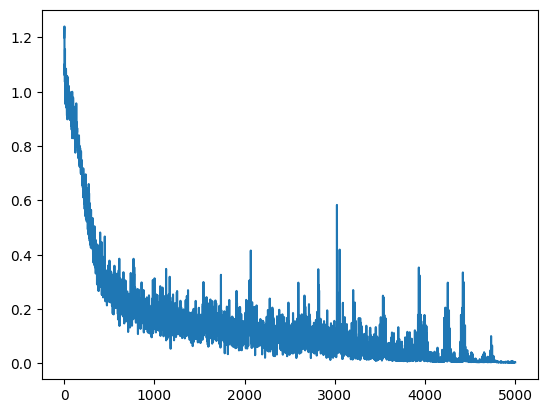

In [36]:

plt.plot(loss_history)

In [37]:

# # function to generate output sequence using greedy algorithm
# def greedy_decode(model, src, src_mask, max_len):
#     """First attempt at non-autoregressive decoding."""
    
#     ys = torch.cat((src[:9], torch.tensor([EOS_TOKEN]).to(DEVICE)), dim=0).unsqueeze(0)
#     src = src.to(DEVICE)
#     src_mask = None  
    
#     # For a single example evaluation, we need to add a dummy batch dimension (1, *) with unsqueeze(0)
#     memory = model.encode(src.unsqueeze(0), src_mask)    
#     memory = memory.to(DEVICE)

#     out = model.decode(tgt=ys, memory=memory, tgt_mask=None) # (1, tgt_seq_len, emb_dim)
#     prob = model.generator(out) # (1, tgt_seq_len, num_tokens)
#     _, pred = torch.max(prob, dim=2)

#     return pred.squeeze(0)


In [41]:
model.eval()
# sample a batch of data
torch.manual_seed(1337) # to get what andrej karpathy got
xb, yb = get_batch('train')

for i in range(batch_size):
    x, y = xb[i], yb[i]
    print(x.shape)
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    print(x.shape)
    break

    src_mask = make_src_mask(N_BITS)
    tgt_mask = ucan_transformer.generate_square_subsequent_mask(N_BITS + 2, device=DEVICE)
    # evaluate the loss
    logits = model(x, y, src_mask, tgt_mask)
    print('logits:', logits.shape)
    print('loss:', loss)

    # sample the output from the logits
    _, preds = torch.max(logits, dim=1)
    print("x    ", x.squeeze(0))
    print("logits", logits)
    print("preds", preds)
    print("y    ", y.squeeze(0))
    print()

# -----------------------------------------------
# GENERATING SEQUENCES
max_len = N_BITS + 2

for i in range(batch_size):
    x, y = xb[i], yb[i]
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    src_mask = make_src_mask(N_BITS)

    memory = model.encode(x, src_mask).to(DEVICE) # now this is phi(x), shape (1, 2*N_BITS + 2, emb_dim)
    ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)


    print("input", x)
    print("target", y)
    for i in range(max_len - 1): # -1 since we start with SOS
        tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE) 
        out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(x.data).fill_(next_word)], dim=1)
        # print(out, "out")
        # print(ys, "ys")
        # print(prob, "prob")
        # print()
    print("final output", ys)
    print()


# tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE) 

# # This mask sets -inf to True, which is correct according to `Transformer` docs
# i = 0
# out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
# print("out.shape", out.shape)
# logits = model.generator(out[:, -1])
# # logits = model.generator(out)
# print("logits.shape", logits.shape)

# _, preds = torch.max(logits, dim=-1)
# print("ys  ", ys)
# print("pred:", preds)

# print(memory)



torch.Size([16])
torch.Size([1, 16])
input tensor([[2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3]], device='cuda:0',
       dtype=torch.int32)
target tensor([[2, 0, 0, 0, 1, 1, 1, 0, 3]], device='cuda:0')
final output tensor([[2, 0, 0, 0, 1, 1, 1, 0, 3]], device='cuda:0')

input tensor([[2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 3]], device='cuda:0',
       dtype=torch.int32)
target tensor([[2, 0, 1, 0, 1, 1, 1, 0, 3]], device='cuda:0')
final output tensor([[2, 0, 1, 0, 1, 1, 1, 0, 3]], device='cuda:0')

input tensor([[2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 3]], device='cuda:0',
       dtype=torch.int32)
target tensor([[2, 1, 0, 1, 1, 1, 0, 1, 3]], device='cuda:0')
final output tensor([[2, 1, 0, 1, 1, 1, 0, 1, 3]], device='cuda:0')

input tensor([[2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3]], device='cuda:0',
       dtype=torch.int32)
target tensor([[2, 1, 0, 1, 1, 1, 0, 1, 3]], device='cuda:0')
final output tensor([[2, 1, 0, 1, 1, 1, 0, 1, 3]], device='cuda:0')



In [15]:
xv, yv = get_batch('val')
src = xv[0]
truth = yv[0]

src = src.to(DEVICE)
src_mask = None
max_len = 10

# For a single example evaluation, we need to add a dummy batch dimension (1, *) with unsqueeze(0)
memory = model.encode(src.unsqueeze(0), src_mask)
# The [1, 1] shape starts us off with a dummy batch dimension 
ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)

print(memory)

for i in range(max_len - 1): # -1 since we start with SOS
    memory = memory.to(DEVICE)
    tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE)).to(DEVICE)
    print(tgt_mask)
    out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)


    prob = model.generator(out[:, -1])
    print(out, "out")
    print(ys, "ys")
    print(prob, "prob")
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    print()


tensor([[[-2.7868,  0.3571,  0.2683, -0.3423,  0.8015,  0.9599, -0.7208,
           0.0275,  0.1133,  0.3672, -0.5141,  1.3417],
         [-1.1109,  0.3338,  0.3859, -1.4481, -0.9562,  2.0624,  1.2049,
          -0.6362,  0.2811,  0.6141, -0.8774,  0.0184],
         [-1.1241,  0.2551,  0.4137, -1.4547, -0.9476,  2.0578,  1.2247,
          -0.6118,  0.2941,  0.6032, -0.8785,  0.0387],
         [-1.1677,  0.2572,  0.3904, -1.4032, -0.9617,  2.0293,  1.3103,
          -0.5942,  0.2802,  0.5733, -0.8782,  0.0352],
         [-1.2104,  0.3464,  0.3609, -1.3546, -0.9713,  1.9936,  1.3736,
          -0.5989,  0.2561,  0.5441, -0.8755,  0.0084],
         [-1.9315, -0.6380,  1.4399,  0.3022,  1.0120,  0.4055, -1.1799,
           0.0860, -0.1640,  0.7048, -1.2249,  1.0884],
         [-1.9339, -0.5638,  1.4427,  0.2349,  1.0007,  0.4492, -1.2247,
           0.1311, -0.1612,  0.6739, -1.2345,  1.0857],
         [-1.1189,  0.3520,  0.4719, -1.5429, -0.8868,  2.0529,  1.1527,
          -0.6148,  0.27

In [101]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len):
    """Standard autoregressive decoder output scheme.

    Current issue: my train batching didn't have time-sliced data, so I think the 
    model has no idea what to do with a length-1 <SOS> sequence as input.
    """
    src = src.to(DEVICE)
    # src_mask = src_mask.to(DEVICE)
    src_mask = None  # FIXME
    
    # For a single example evaluation, we need to add a dummy batch dimension (1, *) with unsqueeze(0)
    memory = model.encode(src.unsqueeze(0), src_mask)
    # The [1, 1] shape starts us off with a dummy batch dimension 
    ys = torch.ones(1, 1).fill_(SOS_TOKEN).type(torch.long).to(DEVICE)

    # FIXME: should I enforce the length? Or should I enforce the length+1, 
    # and then checksum for an EOS? Or should I allow variable length :(
    for i in range(max_len - 1): # -1 since we start with SOS
        memory = memory.to(DEVICE)
        tgt_mask = (ucan_transformer.generate_square_subsequent_mask(ys.size(1), device=DEVICE).type(torch.bool)).to(DEVICE)
        out = model.decode(tgt=ys, memory=memory, tgt_mask=tgt_mask) # (1, tgt_seq_len, emb_dim)
        prob = model.generator(out[:, -1])
        print(out, "out")
        print(ys, "ys")
        print(prob, "prob")
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        print()
    return ys

# actual function to translate input sentence into target language
# inp
def translate(model: torch.nn.Module, src):
    """
    Args:
        src: tensor. single input bitstring of length 2n + 2. Shape (2n + 2,) 
    """
    model.eval()
    seq_len = src.shape[0] - 2
    out_len = seq_len // 2 + 2 # 2:1 UCAN conversion, plus EOS/SOS
    # src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    src_mask = None
    tgt_tokens = greedy_decode(model, src, src_mask, max_len=out_len).flatten()

    return tgt_tokens


xv, yv = get_batch('val')

for xvi, yvi in zip(xv, yv):
    print("xv_i", xvi)
    pred = translate(model, xvi)
    print("yv_i", yvi)
    print("prediction", pred)
    print()

xv_i tensor([2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 3], device='cuda:0',
       dtype=torch.int32)
tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -0.7045, -2.1012,  0.1954, -0.7587]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>) out
tensor([[2]], device='cuda:0') ys
tensor([[ 1.9841,  2.0354, -0.7844, -2.5241]], device='cuda:0',
       grad_fn=<AddmmBackward0>) prob

tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -0.7045, -2.1012,  0.1954, -0.7587],
         [ 0.1536,  0.5132,  1.7468,  0.0826,  2.0158, -0.1218, -1.1890,
          -0.9465, -1.5047, -2.0150,  0.5374,  0.9175]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>) out
tensor([[2, 1]], device='cuda:0') ys
tensor([[ 2.3561,  2.4091, -2.6605, -1.6287]], device='cuda:0',
       grad_fn=<AddmmBackward0>) prob

tensor([[[-0.5963,  1.6153,  1.8461, -0.1170,  1.5781,  0.5869, -1.1237,
          -0.3987, -

In [ ]:
# TODO: Try to use DataLoader, Dataset, etc. for batching

def train_step(model, optimizer):
    losses = 0

    for _ in range(n_steps):
        # These aren't technically epochs i guess.
        xb, yb = get_batch('train')

        logits = model(xb, yb, None, None) # No masks for now
        optimizer.zero_grad(set_to_none=True) #?

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), yb.reshape(-1))
        loss.backward()
        
        optimizer.step()
        losses += loss.item() / BATCH_SIZE # check this

    return losses


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [61]:
emb_size = 10
x, y = get_batch('train')
embedding = TokenEmbedding(2, emb_size)
xx = embedding.forward(x)
print(xx.shape, "embedding")
positional = PositionalEncoding(emb_size, 0.1)
xxx = positional.forward(xx)
print(xxx.shape, "positional")

xxxx = model.forward(x, y, None, None)
print(xxxx.shape, "model forward")


torch.Size([4, 16, 10]) embedding
torch.Size([4, 16, 10]) positional
torch.Size([4, 8, 2]) model forward


### TODO

Re-adapt this for prediction/evaluation, and probably incorporate as a function into the transformer model

In [ ]:

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

---

#### Scratchwork

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
# inp
def translate(model: torch.nn.Module, src):
    """
    Args:
        single
    """
    model.eval()
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))


In [ ]:

from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SRC_LANGUAGE = 'fuck'
TGT_LANGUAGE = 'this'

# Place-holders
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [107]:
from torch.utils.data import DataLoader
from torchtext.datasets import multi30k, Multi30k

# Fixme
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

ModuleNotFoundError: No module named 'torchtext'